### In this project, an image classification algorithm was written using singular value decomposition and SVM. For this purpose, the MNIST number set was used, where the training data consists of images of digits, and the target value is the digit itself.

First, the necessary libraries are imported:

In [1]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

Next, the training and test data sets are read as arrays:

In [2]:
data = np.load('mnist.npz')
X_test_total, X_train_total, y_train_total, y_test_total = data['x_test'], data['x_train'], data['y_train'], data['y_test']

Next, two digits are allocated, which will be further determined, for example, 3 and 8:

In [3]:
num1, num2 = 3, 8

The next step is to form the lists of indices i such that the target of i-th object of training data is either num1 or num2. The same is done for the test dataset.

In [4]:
train_indx = [y == num1 or y == num2 for y in y_train_total] 
test_indx = [y == num1 or y == num2 for y in y_test_total]

Forming new arrays consisting of the data with the target values num1 and num2 only:

In [5]:
X_train, y_train = X_train_total[train_indx], y_train_total[train_indx]
X_test, y_test = X_test_total[test_indx], y_test_total[test_indx]

### Looking at the data

Checking the sizes of the datasets and the shape of one image:

In [6]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Data shapes: 
X_train:  (11982, 28, 28)
y_train:  (11982,)
X_test:  (1984, 28, 28)
y_test:  (1984,)


In [7]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

n_train, n_test

(11982, 1984)

In [8]:
print('Shape of one item: ')
print(X_train[0].shape)

Shape of one item: 
(28, 28)


Train data are images of digits.

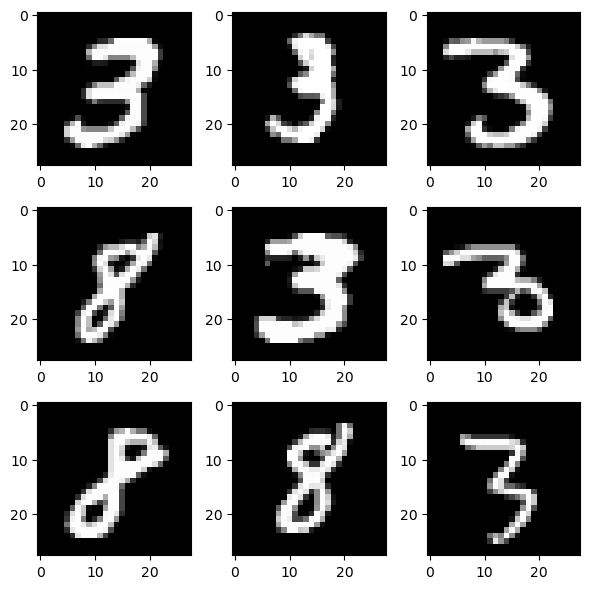

In [9]:
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.tight_layout()
plt.show()

Target values are numbers.

In [10]:
y_train[:9]

array([3, 3, 3, 8, 3, 3, 8, 8, 3], dtype=uint8)

### Step 1
Now data is 3-dimensional of shape (number of images, n_pixels, n_pixels). To work with PCA and SVM, it is important to flatten the images by turning each of them into an array of shape (n_pixels x n_pixels).

In [11]:
def flatten_image(X):
    return X.reshape(-1)

In [12]:
X_train_flat = np.array([flatten_image(img) for img in X_train])
X_test_flat = np.array([flatten_image(img) for img in X_test])
X_test_flat.shape, X_test_flat.shape

((1984, 784), (1984, 784))

PCA works best when the data is scaled, so let's scale our data. For this, [StandartScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) will be used. Scaling replaces a collection of vectors x by the collection of the vectors $x' = (x-M)/D$, where $M$ is the mean vector of
the sample, $D$ is the vector of standard deviations of all components of the vectors, and the division is component-wise. So, the scaled collection has the same size as the original one, and each column has 0 mean and unit standard deviation.

In [13]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

### Why is scaling important for PCA?

The following are some computer experiments to answer this question.

In [14]:
N = 200
P = 5
rho = 0.5

X = np.random.normal(size=[N,P])
X = np.append(X, 3*np.random.choice(2, size = [N,1]), axis = 1)

Let's first try to do PCA without any pre-processing:

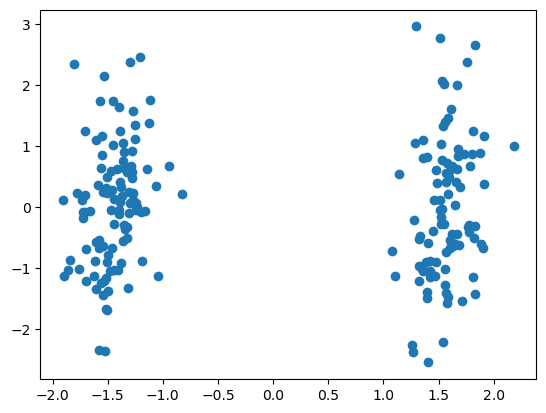

In [15]:
# without preprocessing
pca = PCA(2)
low_d = pca.fit_transform(X)
plt.scatter(low_d[:,0], low_d[:,1])

In this case, two clusters are clearly visible, but the data were generated comletely at random with structure at all

Normalizing changes the plot, but we still see 2 clusters:

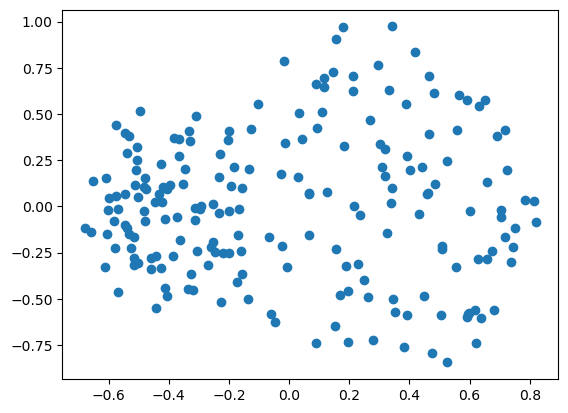

In [16]:
# normalize
Xn = sklearn.preprocessing.normalize(X)
pca = PCA(2)
low_d = pca.fit_transform(Xn)
plt.scatter(low_d[:,0], low_d[:,1])

The fact that the binary varible was on a different scale from the others has created a clustering effect where one might not necessarilly exist. This is because the SVC considers it more than other variables as it contributes more to squared error. 
This may be solved by scaling the dataset:

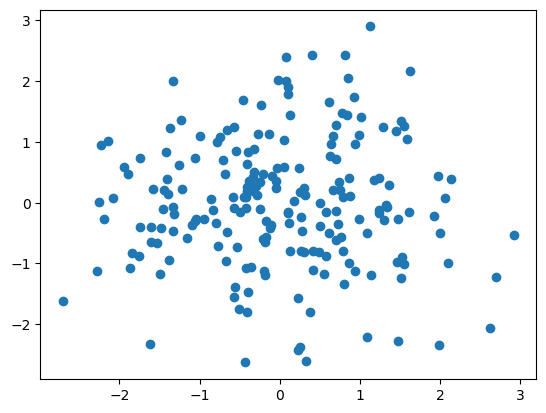

In [17]:
# Scale
Xs = sklearn.preprocessing.scale(X)
low_d = pca.fit_transform(Xs)
plt.scatter(low_d[:,0], low_d[:,1])

Finally it can be seen (correctly) that the data is completely random noise.

Let's try to build model without scaling:

In [18]:
clf = LinearSVC(random_state=42)
clf.fit(X_train_flat, y_train)

LinearSVC(random_state=42)

In [19]:
y_pred = clf.predict(X_test_flat)
acc = np.sum(y_test == y_pred) / y_test.shape[0]
print('Test accuracy: ', acc)

Test accuracy:  0.9581653225806451


Now let's call PCA and reduce the number of components for each vector:

In [20]:
pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)

In [21]:
X_test_flat = pca.transform(X_test_flat)

In [22]:
X_test_flat.shape, X_test_flat.shape

((1984, 128), (1984, 128))

### Step 2

Using SVM with the linear kernel to separate the two classes:

In [23]:
%%time
clf = LinearSVC(random_state=42)
clf.fit(X_train_flat, y_train) 

Wall time: 3.72 s


LinearSVC(random_state=42)

Next, predictions will be made and the accuracy calculated, that is, the ratio of the true predictions to the test sample size.  To do this, [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) is used as a quality indicator:

$$accuracy(y\_true, y\_pred) = \frac{1}{n}\sum_{i=1}^n [y\_true_i=y\_pred_i],$$ where $[a=b]=1$, if $a=b$, and $0$ otherwise.

In [24]:
y_pred = clf.predict(X_test_flat)
acc = np.sum(y_test == y_pred) / y_test.shape[0]
print('Test accuracy: ', acc)

Test accuracy:  0.9682459677419355


### Using my own input

To do this, I drew a number with a graphics editor and edited so that the input image is a white number on a black background, like the numbers in the MNIST dataset.

In [25]:
from scipy import misc
from PIL import Image

In [26]:
image = Image.open('3.png').convert('L')
new_image = image.resize((28, 28))
custom = np.array(new_image)
custom.shape

(28, 28)

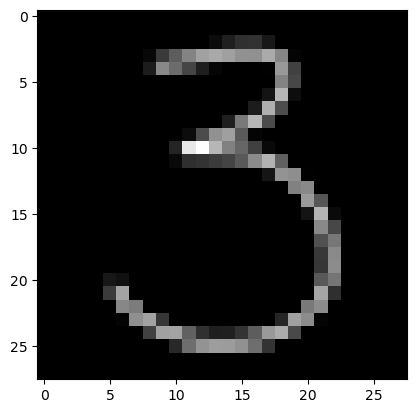

In [27]:
plt.imshow(custom, cmap='gray')
plt.show()

Re-shaping image and making a prediction:

In [28]:
custom = flatten_image(custom).reshape(1, -1)
custom = scaler.transform(custom)
custom = pca.transform(custom)
custom.shape

(1, 128)

In [29]:
clf.predict(custom)

array([3], dtype=uint8)

### Step 3

Next, another approach will be tested, which is described [here](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) in Section 3. For each digit, a new matrix $A$ will be created whose columns are flattened images of this digit. The first several (say, 10) columns of the matrix $U$ from SVD decomposition of $A$ represent a collection of "typical" images of this digit. Given an unrecognized flatten image, among average typical flattened images can be found the closets one. Its target value is considered as a prediction for the target of the unrecognized image.

### SVD refesher
SVD of a matrix $A$ is a decomposition:
$A = U \Sigma V^T,$ where $U$ and $V$ are orthogonal matrices. Some SVD properties will be used in this method.

In [30]:
def getSingularVectorsLeft(matrix, number=10): # let's take first 10 numbers
    # returning first _number_ columns of U from SVD of _matrix_
    u, s, v = svd(matrix)
    return u[:, :number]

In [31]:
def getSingularImage(X_train, y_train, number):
    # finding images whose target is _number_
    
    indices = [y == number for y in y_train]
    images = X_train[indices]
    matrix = np.zeros((images[0].shape[0]**2, 1))
    
    for image in images:
    # iteratively append new column to form matrix A    
       matrix = np.hstack((matrix, np.reshape(image, (len(image)**2, 1)))) 

    return getSingularVectorsLeft(matrix[:, 1:])


Trying first on "0":

In [32]:
left_basis = getSingularImage(X_train_total, y_train_total, 0)

assert left_basis.shape, (784, 10)

### Step 4

Next, the first 9 single images of the digit 0 will be built, for this, the columns of the U matrix will be taken and converted back to 28x28 images.

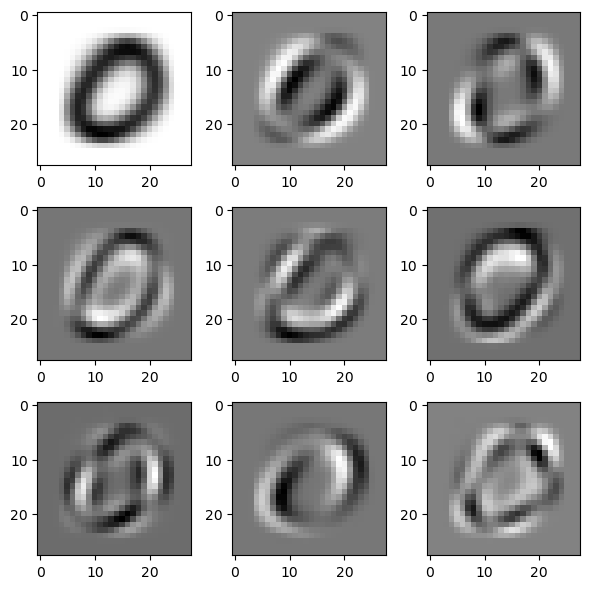

In [33]:
#singular images
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    img = np.reshape(left_basis[:, i], (28, 28))
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

Now let's move on and obtain singular images for all numbers. The matrices $U_k$ from  [the article](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) are represented as `number_basis_matrices[k]`. 
Using getSingularImage function to get matrices for all numbers:

In [34]:
number_basis_matrices = [getSingularImage(X_train_total, y_train_total, i) for i in range(10)] 

### Step 5

Next, the first singular image of each digit will be built, similarly to the previous task.

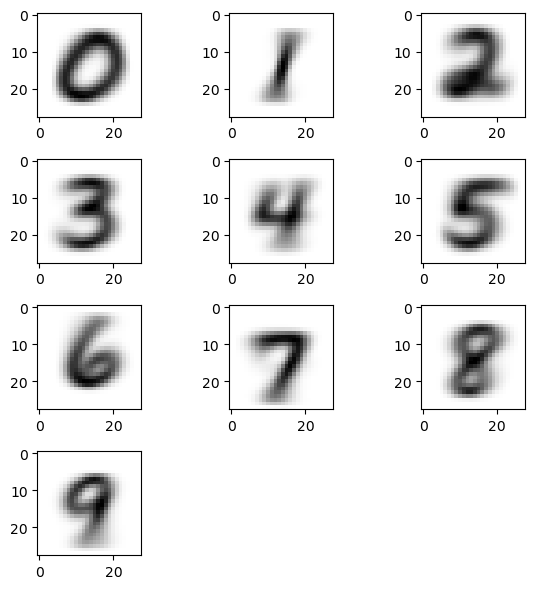

In [35]:
plt.figure(figsize=(6,6))
a, b = 3, 4
for i in range(10):  
    plt.subplot(b, a, i+1)
    # first column of U_k in number_basis_matrices[i] reshaped into 28x28 image
    img = np.reshape(number_basis_matrices[i][:, 0], (28, 28))
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [36]:
dim = number_basis_matrices[0].shape[0]

### Step 6

Next, a new projection matrix will be calculated for each $U_k$ to apply later in testing:
$pr = (I - U_k \cdot U_{k}^{T})$. `numpy.matmul` is used to multiply matrices and `numpy.identity` to create an identity matrix.

In [37]:
numeric_values = [
    np.identity(number_basis_matrices[i].shape[0]) - np.matmul(
        number_basis_matrices[i],
        np.transpose(number_basis_matrices[i])
    ) for i in range(10)
]

### Step 7

Below is a function that uses `numeric_values` matrices to predict labels for unknown images.

In [38]:
def find_closest(test_value, numeric_values):
    stacked_test = test_value.reshape(-1, 1)
    # finding closest U_k to test_value using norm and returning the target digit
    target = -1
    min_value = -np.inf
    for index, matrix in enumerate(numeric_values):
        dist = np.linalg.norm(matrix@stacked_test)
        if dist < min_value:
            min_value = dist
            target = index
    
    return target

Finding array of predictions for test values and calculating accuracy in the cell below:

In [39]:
y_pred = np.array([find_closest(test_value, numeric_values) for test_value in X_test]) 

In [40]:
acc = accuracy_score(y_test, y_pred)
acc

0.0

### Addition
Above Linear SVM has been trained to separate 3s and 8s. This step will implement a multiclass classification for _all_ numbers in `MNIST`. To do this, the same LinearSVC function for “one-vs-the-rest” multi-class strategy ([the documentation](https://scikit-learn.org/stable/modules/svm.html#classification)):

In [41]:
# flatten
X_train_total_flat = np.array([flatten_image(img) for img in X_train_total])
X_test_total_flat = np.array([flatten_image(img) for img in X_test_total])

# Scandart Scaler
scaler = StandardScaler()
X_train_total_flat = scaler.fit_transform(X_train_total_flat)
X_test_total_flat = scaler.transform(X_test_total_flat)

# PCA
pca = PCA(n_components=128, random_state=42)
X_train_total_flat = pca.fit_transform(X_train_total_flat)
X_test_total_flat = pca.transform(X_test_total_flat)

# LinearSVC
clf = LinearSVC(random_state=42)
clf.fit(X_train_total_flat, y_train_total)
y_pred_total = clf.predict(X_test_total_flat)

Calculating accuracy:

In [42]:
acc = accuracy_score(y_test_total, y_pred_total) 
print('Test accuracy: ', acc)

Test accuracy:  0.9079
